In [32]:
import utils
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D, Reshape, Concatenate, Input
from keras.regularizers import L1, L2, L1L2
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [33]:
# Load the Dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769


(2115, 22, 1000)


In [34]:
ind_valid = np.random.choice(2115, 200, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Shuffle the data after adding the noise to them so that the noisy examples 
# are not all together
x_train, y_train = utils.addNoisyExamplesToData(x_train, y_train, 6000, 0, 1)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
print(x_train.shape)
print(y_train.shape)

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)

# Reshape so that each example is three-dimensional 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Axis swapping
x_train = np.swapaxes(x_train, 1, 3)
x_train = np.swapaxes(x_train, 1, 2)
x_valid = np.swapaxes(x_valid, 1, 3)
x_valid = np.swapaxes(x_valid, 1, 2)
X_test = np.swapaxes(X_test, 1, 3)
X_test = np.swapaxes(X_test, 1, 2)

x_train = x_train[:, 0:600, :, :]
x_valid = x_valid[:, 0:600, :, :]
X_test = X_test[:, 0:600, :, :]

print(x_train.shape)

(7915, 22, 1000)
(7915,)
(7915, 600, 1, 22)


# Approach 4: Inception Network
Although the residual network did provide some improvement, a better approach can be to potentially leverage the Inception Module architecture from GoogleNet. The goal here is to leverage an inception layer such that certain features are more intelligently selected by the model.

In [62]:
def InceptionModule(input, filters):
  path_1 = Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')(input)
  path_1 = BatchNormalization()(path_1)
  path_1 = Dropout(0.6)(path_1)
  path_1 = Conv2D(filters=filters, kernel_size=(15, 1), padding='same', activation='relu')(path_1)
  path_1 = BatchNormalization()(path_1)
  path_1 = Dropout(0.6)(path_1)
  
  path_2 = Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')(input)
  path_2 = BatchNormalization()(path_2)
  path_2 = Dropout(0.6)(path_2)
  path_2 = Conv2D(filters=filters, kernel_size=(5, 1), padding='same', activation='relu')(path_2)
  path_2 = BatchNormalization()(path_2)
  path_2 = Dropout(0.6)(path_2)

  path_3 = MaxPooling2D(pool_size=(3, 1), strides=(1, 1), padding='same')(input)
  path_3 = Conv2D(filters=filters, kernel_size=(1, 1), padding='same', activation='relu')(path_3)
  path_3 = BatchNormalization()(path_3)
  path_3 = Dropout(0.6)(path_3)

  return Concatenate(axis=3)([path_1, path_2, path_3])

In [63]:
ipt = Input((600, 1, 22))

outputs = Conv2D(filters=20, kernel_size=(20, 1), padding="same", activation="relu")(ipt)
outputs = MaxPooling2D(pool_size=(3, 1), padding="same")(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dropout(0.6)(outputs)

outputs = Conv2D(filters=50, kernel_size=(15, 1), padding="same", activation="relu")(outputs)
outputs = MaxPooling2D(pool_size=(3, 1), padding="same")(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dropout(0.6)(outputs)

outputs = Conv2D(filters=100, kernel_size=(15, 1), padding="same", activation="relu")(outputs)
outputs = MaxPooling2D(pool_size=(3, 1), padding="same")(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dropout(0.6)(outputs)

outputs = Conv2D(filters=150, kernel_size=(5, 1), padding="same", activation="relu")(outputs)
outputs = MaxPooling2D(pool_size=(3, 1), padding="same")(outputs)
outputs = BatchNormalization()(outputs)
outputs = Dropout(0.6)(outputs)

outputs = InceptionModule(outputs, 50)

outputs = Flatten()(outputs)
outputs = Dense(4, activation='softmax')(outputs)

model = Model(inputs=ipt, outputs=outputs, name="ResidualNetwork")
model.summary()



Model: "ResidualNetwork"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_17 (InputLayer)       [(None, 600, 1, 22)]         0         []                            
                                                                                                  
 conv2d_194 (Conv2D)         (None, 600, 1, 20)           8820      ['input_17[0][0]']            
                                                                                                  
 max_pooling2d_75 (MaxPooli  (None, 200, 1, 20)           0         ['conv2d_194[0][0]']          
 ng2D)                                                                                            
                                                                                                  
 batch_normalization_193 (B  (None, 200, 1, 20)           80        ['max_pooling2d_

In [64]:
learning_rate = 1e-3
epochs = 100
cnn_model_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [65]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_model_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_results = model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/100
124/124 [==============================] - 6s 42ms/step - loss: 2.1910 - accuracy: 0.2700 - val_loss: 1.3730 - val_accuracy: 0.3500
Epoch 2/100
124/124 [==============================] - 5s 39ms/step - loss: 1.7586 - accuracy: 0.2857 - val_loss: 1.3721 - val_accuracy: 0.2750
Epoch 3/100
124/124 [==============================] - 5s 40ms/step - loss: 1.5615 - accuracy: 0.3039 - val_loss: 1.4269 - val_accuracy: 0.2400
Epoch 4/100
124/124 [==============================] - 5s 40ms/step - loss: 1.4756 - accuracy: 0.3133 - val_loss: 1.3538 - val_accuracy: 0.3100
Epoch 5/100
124/124 [==============================] - 5s 39ms/step - loss: 1.4249 - accuracy: 0.3268 - val_loss: 1.4001 - val_accuracy: 0.3000
Epoch 6/100
124/124 [==============================] - 5s 41ms/step - loss: 1.3672 - accuracy: 0.3569 - val_loss: 1.3806 - val_accuracy: 0.3450
Epoch 7/100
124/124 [==============================] - 5s 41ms/step - loss: 1.3197 - accuracy: 0.3845 - val_loss: 1.3702 - val_accuracy:

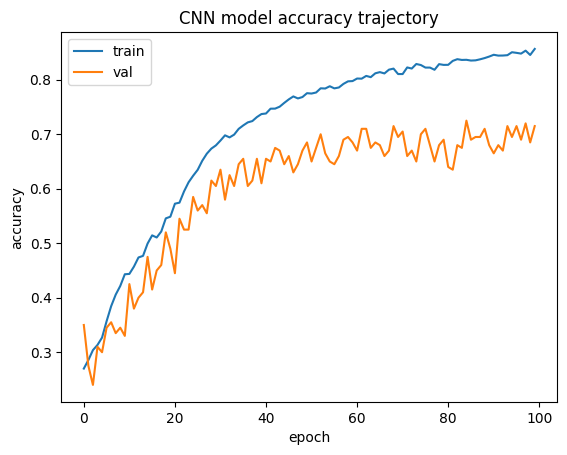

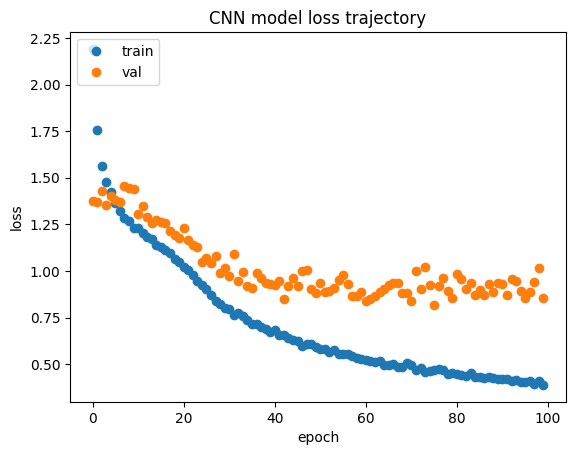

In [66]:
# Plotting accuracy trajectory
plt.plot(cnn_model_results.history['accuracy'])
plt.plot(cnn_model_results.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_results.history['loss'],'o')
plt.plot(cnn_model_results.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [67]:
cnn_model_score_all_subjects = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy Across All Subjects: {score}".format(score=cnn_model_score_all_subjects[1]))

Accuracy Across All Subjects: 0.697516918182373


In [68]:
# Test the model against each individual subject group
for i in range(9):
  indices = np.where(person_test[:, 0] == i)
  x = X_test[indices]
  y = y_test[indices]
  score = model.evaluate(x, y, verbose=0)
  print("Subject {subject} Accuracy: {score}".format(subject=i, score=score[1]))

Subject 0 Accuracy: 0.699999988079071
Subject 1 Accuracy: 0.5600000023841858
Subject 2 Accuracy: 0.800000011920929
Subject 3 Accuracy: 0.7200000286102295
Subject 4 Accuracy: 0.7021276354789734
Subject 5 Accuracy: 0.7142857313156128
Subject 6 Accuracy: 0.6800000071525574
Subject 7 Accuracy: 0.6399999856948853
Subject 8 Accuracy: 0.7659574747085571
